# 🧬 DNA Promoter Classification with BiLSTM

## 📦 1. Imports and Preprocessing

In [2]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F

# ✅ One-hot encoding function
def one_hot_encode(seq):
    mapping = {'a':[1,0,0,0], 't':[0,1,0,0], 'c':[0,0,1,0], 'g':[0,0,0,1]}
    return np.array([mapping.get(char, [0,0,0,0]) for char in seq.lower()])

# 📄 Load dataset
df = pd.read_csv("final_dataset.csv")
df = df.dropna()
df = df[df['sequence'].apply(lambda x: isinstance(x, str))]

# ✅ Encode sequences
X = np.array([one_hot_encode(seq) for seq in df['sequence']])
y = df['label'].values

# 🔀 Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 📦 Dataset class
class DNADataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader = DataLoader(DNADataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(DNADataset(X_test, y_test), batch_size=64)


## 🧠 2. BiLSTM Model Definition

In [3]:
class BiLSTMModel(nn.Module):
    def __init__(self):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=4, hidden_size=64, num_layers=1, bidirectional=True, batch_first=True)
        self.fc1 = nn.Linear(64 * 2, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)            # [B, 60, 128]
        x = lstm_out[:, -1, :]                # Take last time step [B, 128]
        x = torch.relu(self.fc1(x))           # → [B, 64]
        return self.fc2(x)                    # → [B, 2]


## 🚀 3. Training Function

In [8]:
def train_model(model, train_loader, epochs=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

        acc = 100 * correct / total
        print(f"📘 Epoch {epoch+1}/{epochs} — Loss: {total_loss/len(train_loader):.4f}, Accuracy: {acc:.2f}%")
    
    return model


## 📊 4. Evaluation Function

In [9]:
def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model = model.to(device)

    all_preds, all_labels = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.numpy())

    print("\n🧾 Classification Report:")
    print(classification_report(all_labels, all_preds, digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("📌 Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return all_preds, all_labels


## 📈 5. ROC Curve & AUC

In [10]:
def plot_roc(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)

    y_probs, y_true = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            probs = F.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            y_probs.extend(probs)
            y_true.extend(y_batch.numpy())

    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='orange', label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], 'k--', label="Random")
    plt.title("📈 ROC Curve (BiLSTM)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()


## 🏁 6. Train, Evaluate & Plot

📘 Epoch 1/10 — Loss: 0.5992, Accuracy: 66.80%
📘 Epoch 2/10 — Loss: 0.5212, Accuracy: 74.19%
📘 Epoch 3/10 — Loss: 0.5097, Accuracy: 75.15%
📘 Epoch 4/10 — Loss: 0.4958, Accuracy: 75.81%
📘 Epoch 5/10 — Loss: 0.5012, Accuracy: 75.45%
📘 Epoch 6/10 — Loss: 0.4915, Accuracy: 76.23%
📘 Epoch 7/10 — Loss: 0.4850, Accuracy: 76.28%
📘 Epoch 8/10 — Loss: 0.4866, Accuracy: 76.63%
📘 Epoch 9/10 — Loss: 0.4663, Accuracy: 78.23%
📘 Epoch 10/10 — Loss: 0.4581, Accuracy: 78.46%

🧾 Classification Report:
              precision    recall  f1-score   support

           0     0.7662    0.8682    0.8141       774
           1     0.8480    0.7351    0.7875       774

    accuracy                         0.8017      1548
   macro avg     0.8071    0.8017    0.8008      1548
weighted avg     0.8071    0.8017    0.8008      1548



C:\Users\dell\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


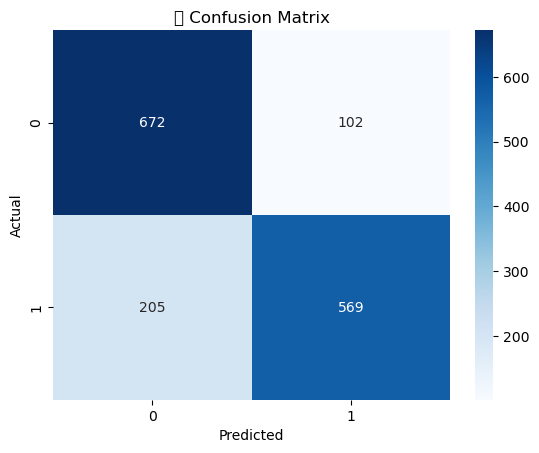

C:\Users\dell\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


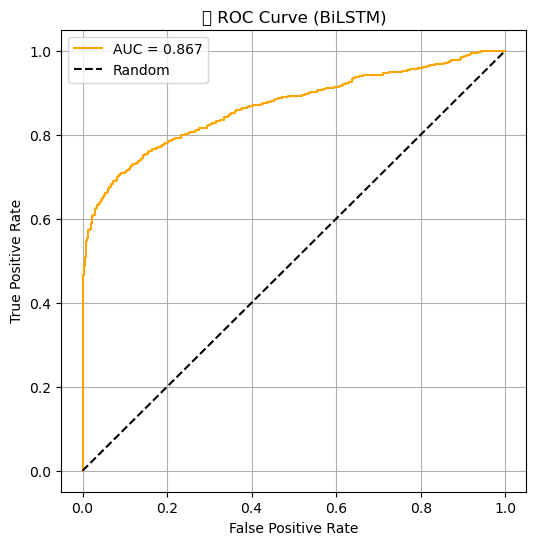

In [11]:
# ✅ Train
model = BiLSTMModel()
model = train_model(model, train_loader, epochs=10)

# 🧪 Evaluate
preds, labels = evaluate_model(model, test_loader)

# 📈 ROC
plot_roc(model, test_loader)


In [12]:
# 💾 Save BiLSTM model
torch.save(model.state_dict(), "bilstm_promoter_model.pth")
print("✅ BiLSTM model saved!")


✅ BiLSTM model saved!
